In [1]:
import os
from nilearn import image as nimg
from nilearn import plotting as nplot
import numpy as np
from numpy import mean
import nibabel as nib
import pandas as pd
from bids.layout import BIDSLayout
import matplotlib
from matplotlib import pylab as plt
import nibabel as nib
from nibabel import nifti1
from nibabel.viewers import OrthoSlicer3D
import skimage.io as io

import xgboost
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.io
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_moons
from sklearn.manifold import SpectralEmbedding
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import shap

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
'''
Load and examined one subjects resting state nii file
'''
img=nib.load('/Users/jacobderosa/ds000030/sub-10159/func/sub-10159_task-rest_bold.nii.gz')
img_arr=img.get_fdata()
img_arr=np.squeeze(img_arr)
img_arr.shape

(64, 64, 34, 152)

In [ ]:
#pheno = pd.read_csv('/Users/jacobderosa/Brown/Brown_TestRelease_phenotypic.csv')
pheno = pd.read_csv('~/ds000030/participants.tsv', sep='\t').iloc[:, 0:2]
pheno = pheno[pheno['participant_id'] != 'sub-10193']
pheno = pheno[pheno['participant_id'] != 'sub-11082']
pheno = pheno[pheno['participant_id'] != 'sub-10948']
pheno = pheno[pheno['participant_id'] != 'sub-70002']

#pheno['Gender'][3] #index of pheno should match index of states -> can be used in list
len(pheno)

pheno['dx'] = np.where(pheno['diagnosis'] == 'CONTROL', 0,
                             np.where(pheno['diagnosis'] == 'ADHD', 1, 
                                np.where(pheno['diagnosis'] == 'BIPOLAR', 2,
                                   np.where(pheno['diagnosis'] == 'SCHZ', 3, False))))

pheno = pheno.reset_index(drop = True)

pheno_list = list(pheno['participant_id'])

In [414]:
#glob_path = "/Users/jacobderosa/Brown/*/"
glob_path = '/Users/jacobderosa/ds000030/*/'
rest_file_path = '/Users/jacobderosa/ds000030/%s/func/%s_task-rest_bold.nii.gz'

from glob import glob

sub_idx = glob(glob_path, recursive = True)

for i in range(0,len(sub_idx)):
    sub_idx[i] = sub_idx[i].replace('/Users/jacobderosa/ds000030/', '').replace('/', '')
    
sub_idx = list(filter(lambda sub_idx: sub_idx != 'sub-10193', sub_idx))
sub_idx = list(filter(lambda sub_idx: sub_idx != 'sub-11082', sub_idx))
sub_idx = list(filter(lambda sub_idx: sub_idx != 'phenotype', sub_idx))
sub_idx = list(filter(lambda sub_idx: sub_idx != 'sub-10948', sub_idx))
sub_idx = list(filter(lambda sub_idx: sub_idx != 'sub-70002', sub_idx))

sub_idx = pheno_list

rest_files = [rest_file_path % (sub, sub) for sub in sub_idx]

from os.path import exists

file_exists=[]
for i in rest_files:
    file_exists.append(exists(i))
    
exists = pd.concat([pd.DataFrame(rest_files), pd.DataFrame(file_exists)], axis = 1)
exists.columns = ['path', 'bool']
not_exists = exists[exists['bool'] == False]

In [416]:
def get_states(lst, subj):
    
    #from nilearn.input_data import NiftiMasker
    #brain_masker = NiftiMasker(smoothing_fwhm=6, detrend=True, standardize=True,
    #                       low_pass=0.1, high_pass=0.01, t_r=2., verbose=1,
    #                       memory="nilearn_cache", memory_level=2)
    
    #brain_time_series = brain_masker.fit_transform(lst[subj])
    # the brain time series is an array with shape (n_volumes, n_voxels).
    #brain_time_series.shape
    #(251, 143328) -> volumnes, voxels 
    #X = pd.DataFrame(brain_time_series) 
    
    
    from nilearn import datasets
    atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011()
    atlas_yeo = atlas_yeo_2011.thick_17

    # Let's now plot it
    from nilearn import plotting

    #plotting.plot_roi(atlas_yeo, title='Original Yeo atlas',
    #                  cut_coords=(8, -4, 9), colorbar=True, cmap='Paired')

    from nilearn.input_data import NiftiLabelsMasker
    masker = NiftiLabelsMasker(labels_img=atlas_yeo, standardize=True, verbose=1,
                               memory="nilearn_cache", memory_level=2)

    time_series = masker.fit_transform(lst[subj])
    X = pd.DataFrame(time_series) 
    
    #kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    #pred_y = kmeans.fit_predict(X)
    
    from sklearn.cluster import SpectralClustering
    model = SpectralClustering(n_clusters=5, affinity='nearest_neighbors',
                              assign_labels='kmeans')
    pred_y = model.fit_predict(X)
    
    X = pd.DataFrame(X)
    states = pd.DataFrame(pred_y)
    states.columns = ['state']
    
    state_frame = pd.concat([states, X], axis = 1)

    #col = state_frame.drop(['state'], axis=1).columns
    #for col in state_frame.columns:
    # state_frame[col] = (state_frame[col] - state_frame[col].mean())/state_frame[col].std(ddof=0)

    def state_mean(data, state):
        statef = data[data['state'] == state]
        state_mean = statef.drop(['state'], axis=1).mean()
        time = len(statef)

        return state_mean, time

    state_1, time_1 = state_mean(state_frame, 0)
    state_2, time_2  = state_mean(state_frame, 1)
    state_3, time_3  = state_mean(state_frame, 2)
    state_4, time_4  = state_mean(state_frame, 3)
    state_5, time_5  = state_mean(state_frame, 4)

    
    import matplotlib.pyplot as plt

   # for i in state_0, state_1, state_2, state_3, state_4:
   #     fig = plt.figure(figsize=(8, 4))
   #     plt.plot(i)
   #     plt.xlabel('Scan number')
   #     plt.ylabel('Mean signal')
   #     plt.tight_layout();
    
   # from nilearn import plotting

   # seed_to_voxel_correlations_img = brain_masker.inverse_transform(state_0.T)
   # display = plotting.plot_stat_map(seed_to_voxel_correlations_img,
   #                                  threshold=0.5, vmax=1,
   #                                  #cut_coords=pcc_coords[0],
   #                                  title="Brain State")
     
    return state_1, state_2, state_3, state_4, state_5, time_1, time_2, time_3, time_4, time_5



In [417]:
state_list = []

for i in range(0,len(rest_files)):
        state_list.append(get_states(rest_files, i))


[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_Liberal

Graph is not fully connected, spectral embedding may not work as expected.


[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_Liberal

Graph is not fully connected, spectral embedding may not work as expected.


[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_Liberal

Graph is not fully connected, spectral embedding may not work as expected.


[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_Liberal

Graph is not fully connected, spectral embedding may not work as expected.


[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_Liberal

Graph is not fully connected, spectral embedding may not work as expected.


[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_Liberal

Graph is not fully connected, spectral embedding may not work as expected.


[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_Liberal

Graph is not fully connected, spectral embedding may not work as expected.


[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels


Graph is not fully connected, spectral embedding may not work as expected.


[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels


Graph is not fully connected, spectral embedding may not work as expected.


[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_Liberal

Graph is not fully connected, spectral embedding may not work as expected.


[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /Users/jacobderosa/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_Liberal

In [418]:
def match_states(sub):   
    import pandas as pd
    import numpy as np
    from scipy.stats.stats import pearsonr

    a = state_list[0][0]
    b = state_list[0][1]
    c = state_list[0][2]
    d = state_list[0][3]
    e = state_list[0][4]

    aa = state_list[sub][0]
    bb = state_list[sub][1]
    cc = state_list[sub][2]
    dd = state_list[sub][3]
    ee = state_list[sub][4]

    # To store the data
    dict_series = {'a': a,'b': b,'c':c,'d':d, 'e':e,
                   'aa': aa,'bb': bb,'cc':cc,'dd':dd, 'ee':ee,
                  }
    list_series_names = [i for i in dict_series.keys()]

    def get_max_correlation_from_lists(a, b):
        # This is to make sure the longest list is in the dataframe
        if len(b)>=len(a):
            a_old = a
            a = b
            b= a_old
        # Taking the body from the original code.
        df = pd.DataFrame(dict(x=a))
        CORR_VALS = np.array(b)
        def get_correlation(vals):
            return pearsonr(vals, CORR_VALS)[0]
        # Collecting the max
        return df.rolling(window=len(CORR_VALS)).apply(get_correlation).max().values[0]

    # This is to create the "correlations" matrix
    correlations_matrix = pd.DataFrame(index=list_series_names,columns=list_series_names )
    for i in list_series_names:
        for j in list_series_names:
            correlations_matrix.loc[i,j]=get_max_correlation_from_lists(dict_series[i], dict_series[j])

    cors = pd.DataFrame(correlations_matrix)
    cors
    cors = cors.iloc[5:, 0:5].reset_index(drop = True)
    cors.index = cors.columns

    new = cors.melt()
    new['var'] = ['aa', 'bb','cc', 'dd', 'ee']*5
    new = new[['variable', 'var', 'value']]
    new = new.sort_values(ascending=False, by = 'value').reset_index(drop=True)

    state1_names = new.loc[:0]
    state1_variable = state1_names['variable']
    state1_var = state1_names['var']
    new = new[new['variable'] != state1_variable[0]]
    new = new[new['var'] != state1_var[0]].reset_index(drop=True)

    state2_names = new.loc[:0]
    state2_variable = state2_names['variable']
    state2_var = state2_names['var']
    new = new[new['variable'] != state2_variable[0]]
    new = new[new['var'] != state2_var[0]].reset_index(drop=True)

    state3_names = new.loc[:0]
    state3_variable = state3_names['variable']
    state3_var = state3_names['var']
    new = new[new['variable'] != state3_variable[0]]
    new = new[new['var'] != state3_var[0]].reset_index(drop=True)

    state4_names = new.loc[:0]
    state4_variable = state4_names['variable']
    state4_var = state4_names['var']
    new = new[new['variable'] != state4_variable[0]]
    new = new[new['var'] != state4_var[0]].reset_index(drop=True)

    state5_names = new.loc[:0]

    state_names = pd.concat([state1_names, state2_names, state3_names, state4_names, state5_names])

    state_names['state'] = np.where(state_names['variable'] == 'a', 1,
                             np.where(state_names['variable'] == 'b', 2, 
                                np.where(state_names['variable'] == 'c', 3,
                                   np.where(state_names['variable'] == 'd', 4, 
                                      np.where(state_names['variable'] == 'e', 5, False)))))

    state_names['state_rename'] = np.where(state_names['var'] == 'aa', 0,
                             np.where(state_names['var'] == 'bb', 1, 
                                np.where(state_names['var'] == 'cc', 2,
                                   np.where(state_names['var'] == 'dd', 3, 
                                      np.where(state_names['var'] == 'ee', 4, False)))))

    state_names = state_names.sort_values(ascending=True, by = 'state').reset_index(drop=True)

    state_rename = state_names['state_rename']
    
    return state_rename

In [421]:
all_states = []
time_states = []

for i in range(0, len(state_list)):
    subj_states = pd.concat([state_list[i][0], state_list[i][1], 
                             state_list[i][2], state_list[i][3], state_list[i][4]], axis = 1)
    
    time_subj_states = pd.DataFrame([state_list[i][5], state_list[i][6], state_list[i][7], 
                     state_list[i][8], state_list[i][9]]).T
   
    if i != 0:
        state_rename = match_states(i)
        
        subj_states = subj_states.iloc[:, 0:5][state_rename]
        subj_states.columns = [0,1,2,3,4]
        
        time_subj_states = time_subj_states.iloc[:, 0:5][state_rename]
        time_subj_states.columns = [0,1,2,3,4]
    
    subj_states['dx'] = pheno['dx'][i]
    subj_states['subj'] = i
    
    time_subj_states['dx'] = pheno['dx'][i]
    time_subj_states['subj'] = i 
    
    all_states.append(subj_states)
    time_states.append(time_subj_states)
    
comb_states = pd.concat(all_states)
time_comb_states = pd.concat(time_states)

Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.


In [422]:
from matplotlib import colors as plt_colors
# class names
classes = ['0', '1', '2', '3']
# set RGB tuple per class
colors = [(240/255, 24/255, 10/255), (240/255, 144/255, 21/255), (109/255, 174/255, 68/255), (10/255, 90/255, 240/255)]
# create listed colormap
cmap = plt_colors.ListedColormap(np.array(colors))


def classy(data):
    #est = bootit(df1_rest, 1/5)
    test = data
    
    X = test.iloc[:, 0:5]
    from scipy import stats
    X = stats.zscore(X)
    y = np.array(test['dx'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=10)
    from sklearn.utils.class_weight import compute_sample_weight
    sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

    cls = xgboost.XGBClassifier(objective="multi:softmax", nthread = -1)
    #cls = SVC(kernel='rbf', probability=True, C=1, gamma='scale',random_state=1)
    cls.fit(X_train, y_train
            #sample_weight=sample_weights
           )
    # compute SHAP values
    #explainer = shap.KernelExplainer(model=cls.predict_proba, data = X_train, link = "logit")
    explainer = shap.TreeExplainer(cls)
    shap_values = explainer.shap_values(X)
    
    predictions = cls.predict(X_test)
    print(accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(15, 10))
    plt.subplots_adjust(wspace=0.3)


    plt.subplot(1,2, 1)

    shap.summary_plot(shap_values, X.values, plot_type="bar", 
                      class_names= [0,1,2,3], class_inds='original',
                      feature_names = X.columns, color = cmap, 
                      plot_size=None, show=False)

    from matplotlib import pyplot as plt
    n_top_features = 15

    plt.subplot(1,2,2)
        
    sorted_idx = cls.feature_importances_.argsort()[::-1]
    sorted_values = -np.sort(-cls.feature_importances_[sorted_idx][:n_top_features])
    sorted_cols = X_test.columns[sorted_idx][:n_top_features].tolist()
    plt.barh(sorted_cols,  sorted_values,  align='center')
    #plt.spines['left'].set_color('black')
    #plt.spines['bottom'].set_color('black')
    plt.xlabel('Relative Importance')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    
    plt.show()
    
    return explainer, shap_values, X, X_test


def shapit(data):
    explainer1, shap_values1, X1, X1_test = classy(data)


    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(wspace=0.3)

    for i in [0,1,2,3]:

        plt.subplot(2,2,i+1)

        shap.summary_plot(shap_values1[i], X1.values, feature_names = X1.columns,
                          plot_size=None, show=False)
   
    plt.show()
    plt.clf()
    
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(wspace=0.3)

    for i in [0,1,2,3]:

        plt.subplot(2,2,i+1)

        shap.summary_plot(shap_values1[i], X1_test, plot_type="bar", plot_size=None, show=False)

    plt.show()
    plt.clf()


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


0.5318215069495245
[[516  34  52  52]
 [128  59  14  17]
 [139  13  64  22]
 [140  15  14  88]]
              precision    recall  f1-score   support

           0       0.56      0.79      0.65       654
           1       0.49      0.27      0.35       218
           2       0.44      0.27      0.34       238
           3       0.49      0.34      0.40       257

    accuracy                           0.53      1367
   macro avg       0.50      0.42      0.44      1367
weighted avg       0.52      0.53      0.50      1367



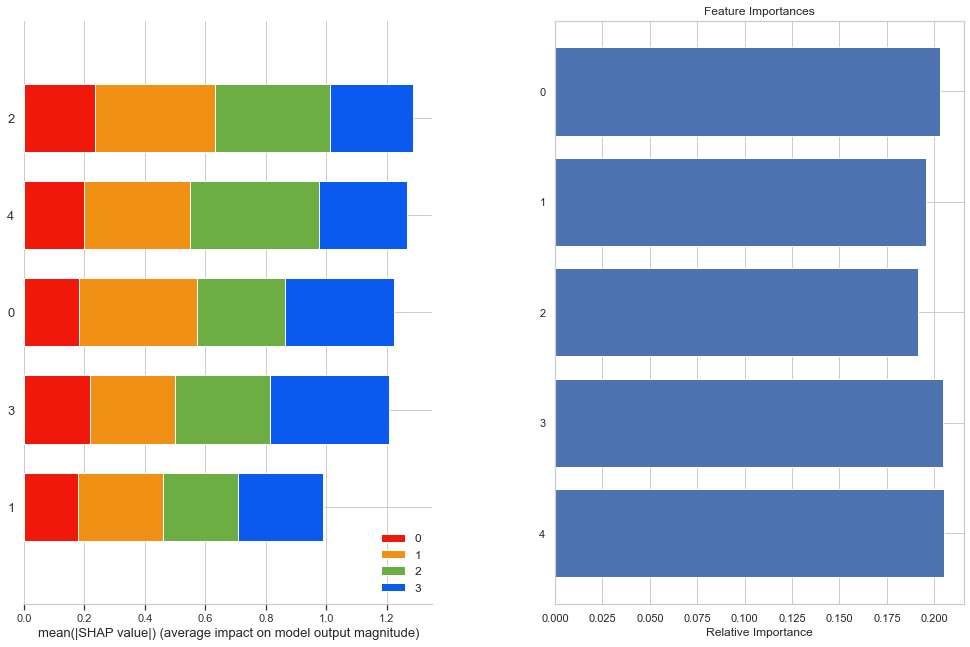

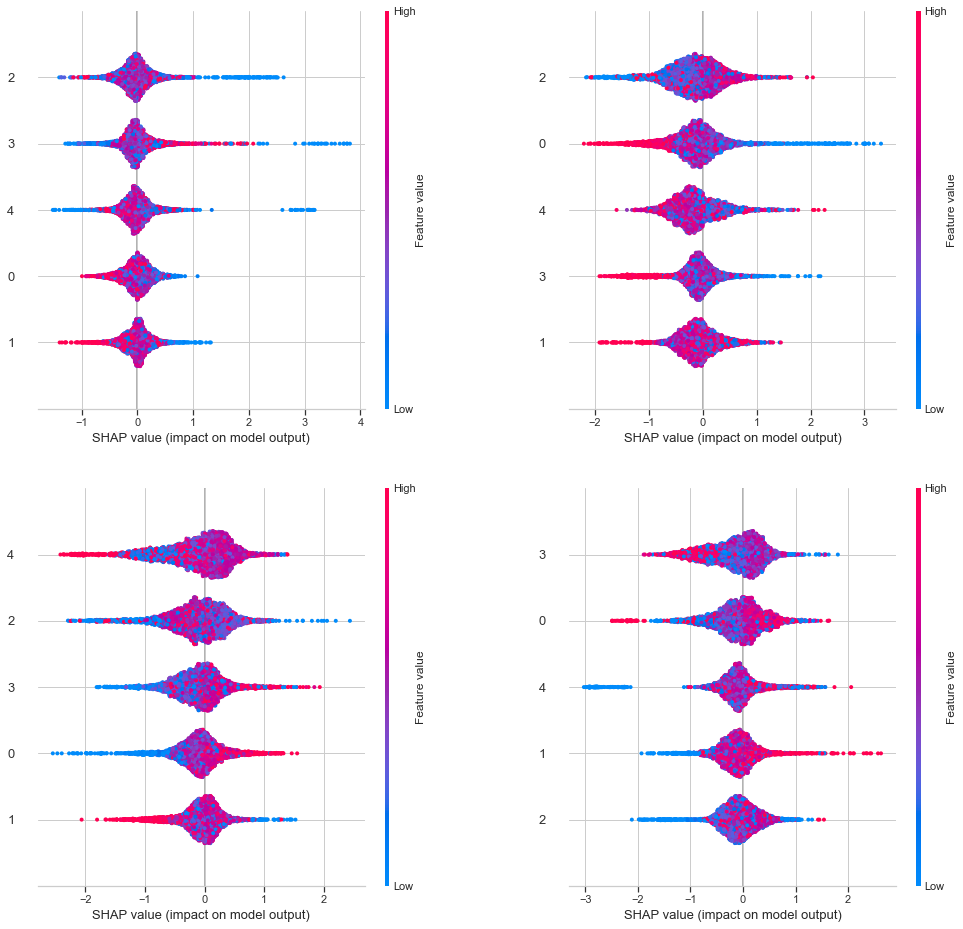

<Figure size 720x504 with 0 Axes>

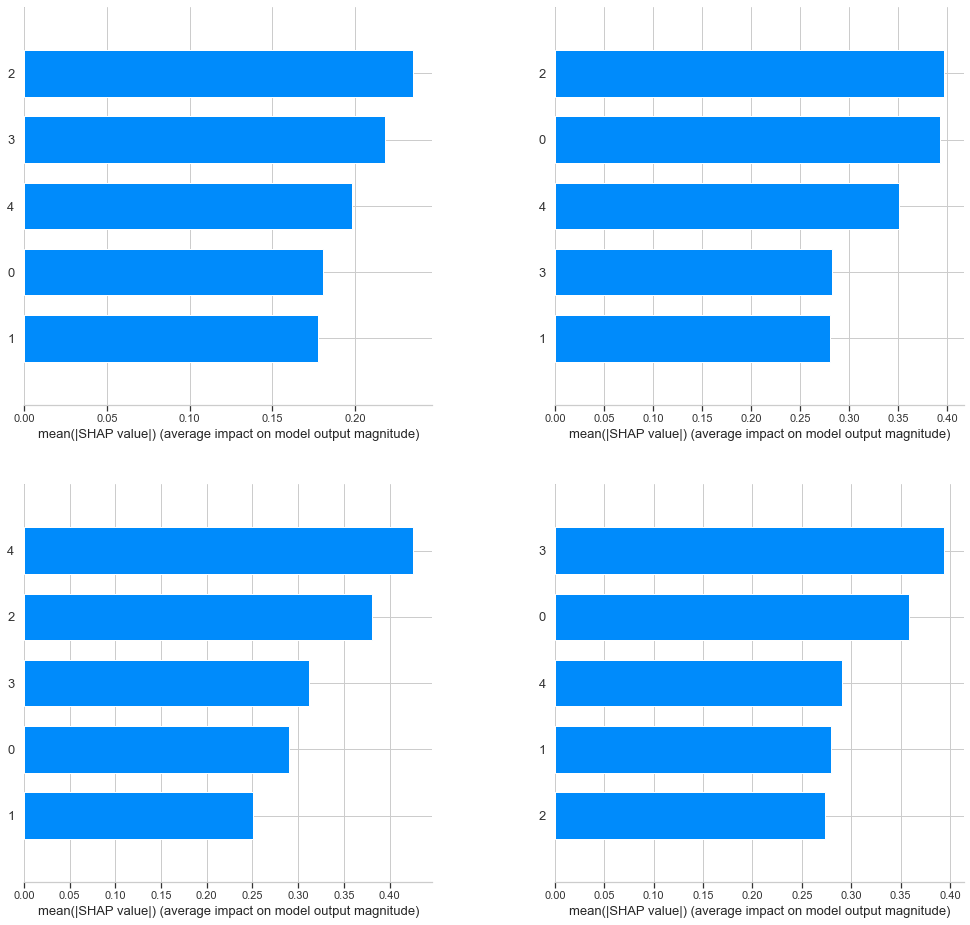

<Figure size 720x504 with 0 Axes>

In [423]:
shapit(comb_states)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


0.35802469135802467
[[18  6  8  4]
 [ 7  2  4  1]
 [ 6  2  1  1]
 [ 7  1  5  8]]
              precision    recall  f1-score   support

           0       0.47      0.50      0.49        36
           1       0.18      0.14      0.16        14
           2       0.06      0.10      0.07        10
           3       0.57      0.38      0.46        21

    accuracy                           0.36        81
   macro avg       0.32      0.28      0.29        81
weighted avg       0.40      0.36      0.37        81



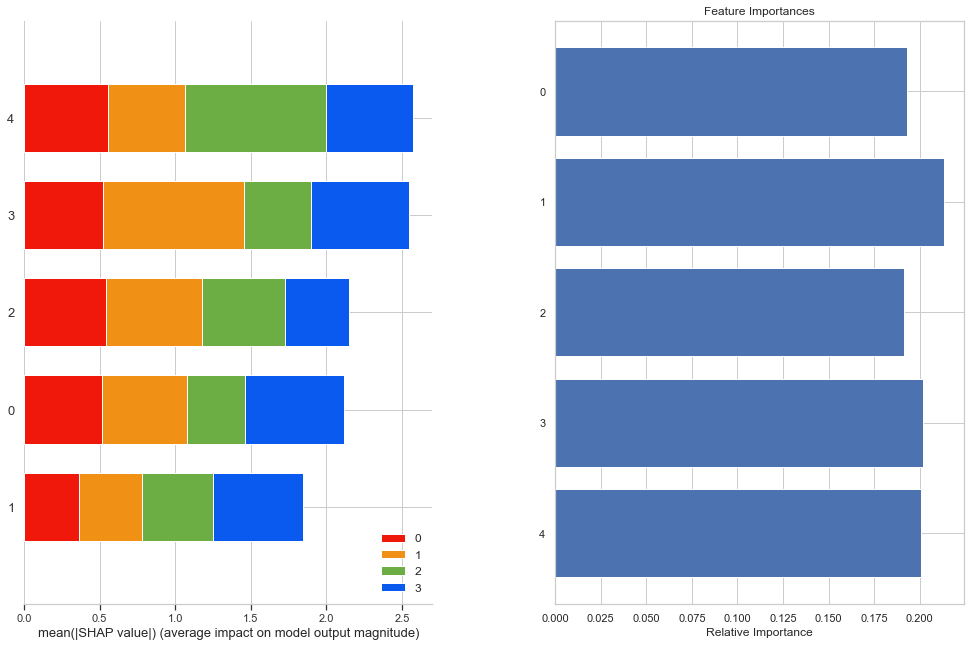

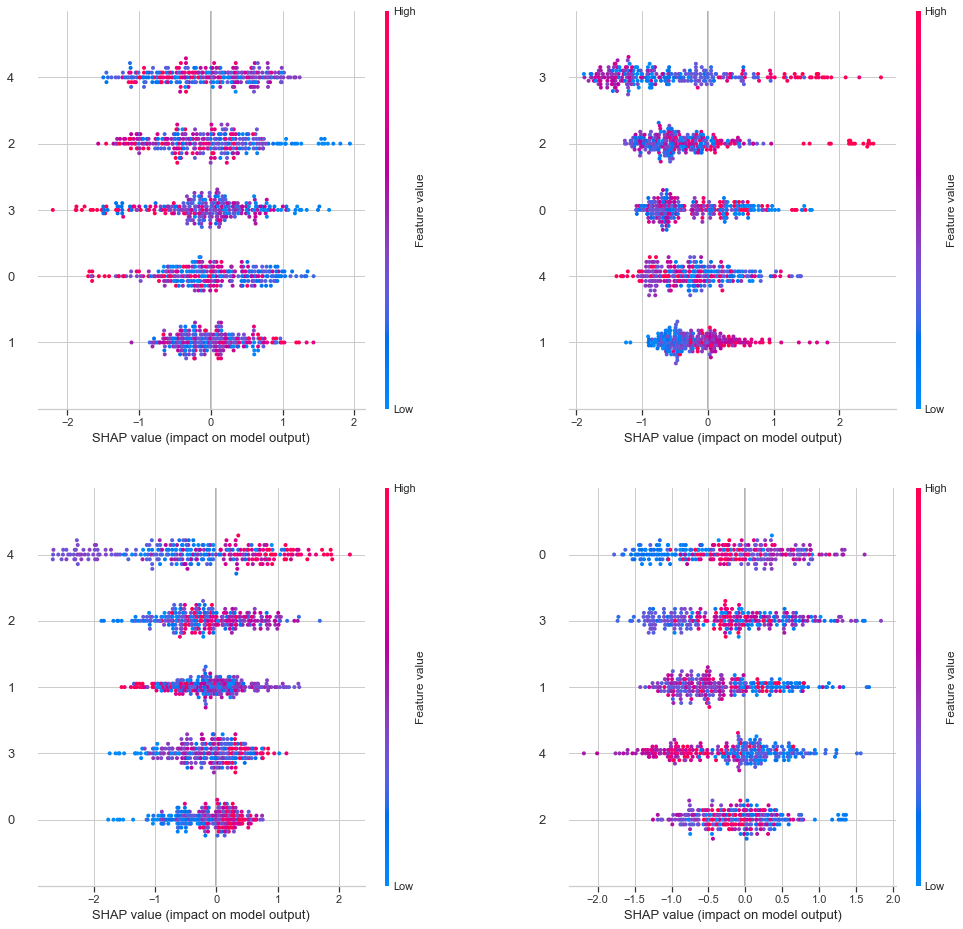

<Figure size 720x504 with 0 Axes>

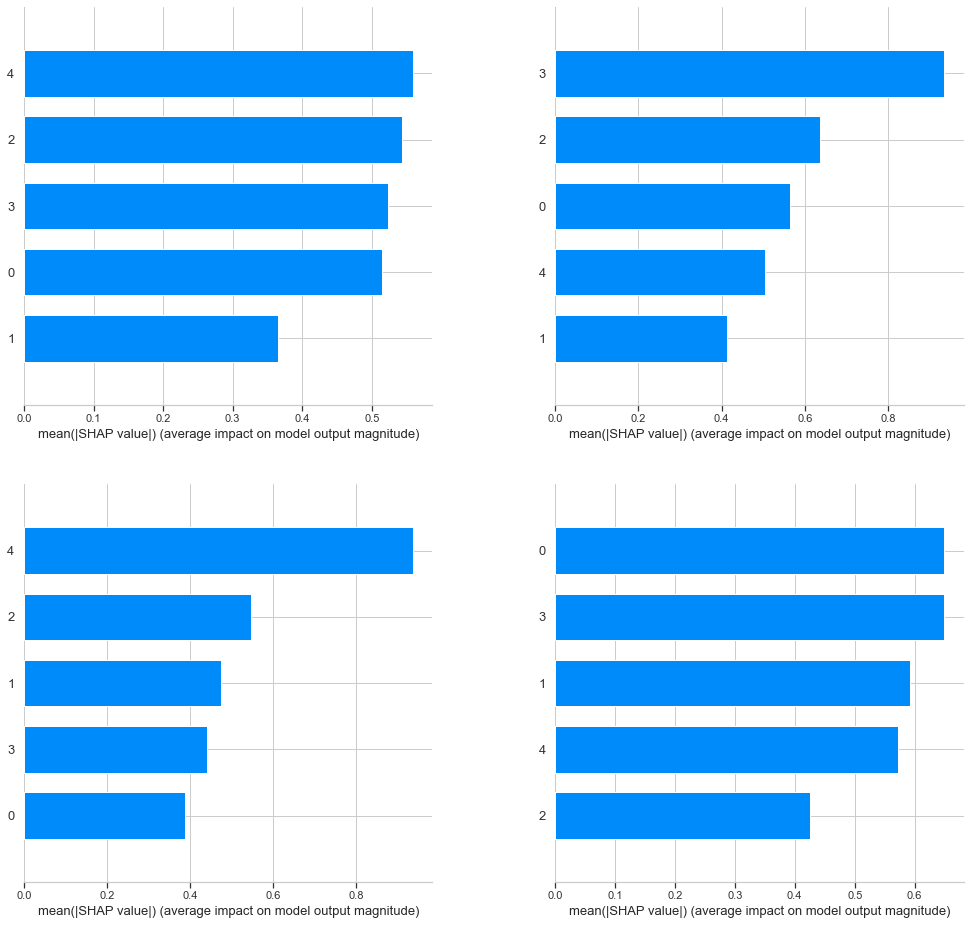

<Figure size 720x504 with 0 Axes>

In [424]:
shapit(time_comb_states)

In [425]:
comb_states['network'] = list(range(0,17))*268

comb_states = comb_states.reset_index(drop = True)

In [426]:
comb_states.columns = ['s1', 's2', 's3', 's4', 's5', 'dx', 'subj', 'network']

In [427]:
def wide_states(state_col):
    state_networks = pd.DataFrame(np.array(comb_states[[state_col, 'dx', 'subj', 'network']].pivot_table(index = ['subj', 'dx'], columns = 'network')))
    state_networks = pd.concat([pheno['dx'], state_networks], axis=1)
    state_networks['state'] = state_col
    
    return state_networks

state_1_networks = wide_states('s1')
state_2_networks = wide_states('s2')
state_3_networks = wide_states('s3')
state_4_networks = wide_states('s4')
state_5_networks = wide_states('s5')

In [428]:
def state_mds(data, filepath=None):

    from scipy import stats
    from sklearn.manifold import MDS
    import scipy.spatial.distance as sp_distance
    import matplotlib.pyplot as plt
    import seaborn as sns 
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import animation

    test_cols = data.drop('state', axis = 1)
    test_cols['c'] = test_cols.dx.map({0:ops_cols[0], 1:ops_cols[1], 2:ops_cols[2], 3:ops_cols[3]})
    test_cols = test_cols.drop('dx', axis = 1)

    embedding = MDS(n_components=3)
    X1 = embedding.fit_transform(test_cols.iloc[:, 0:17])

    dx_mds = pd.concat([pd.DataFrame(pheno['dx']), pd.DataFrame(X1)], axis = 1)
    dx_mds_0 = dx_mds[dx_mds['dx'] == 0]
    dx_mds_1 = dx_mds[dx_mds['dx'] == 1]
    dx_mds_2 = dx_mds[dx_mds['dx'] == 2]
    dx_mds_3 = dx_mds[dx_mds['dx'] == 3]

    dx_mds_0_des = dx_mds_0.describe().T[['mean', 'std']]
    dx_mds_1_des = dx_mds_1.describe().T[['mean', 'std']]
    dx_mds_2_des = dx_mds_2.describe().T[['mean', 'std']]
    dx_mds_3_des = dx_mds_3.describe().T[['mean', 'std']]

    all_x_mean = np.array([dx_mds_0_des['mean'][0], dx_mds_1_des['mean'][0], dx_mds_2_des['mean'][0], dx_mds_3_des['mean'][0]]).flatten()
    all_y_mean = np.array([dx_mds_0_des['mean'][1], dx_mds_1_des['mean'][1], dx_mds_2_des['mean'][1], dx_mds_3_des['mean'][1]]).flatten()
    all_z_mean = np.array([dx_mds_0_des['mean'][2], dx_mds_1_des['mean'][2], dx_mds_2_des['mean'][2], dx_mds_3_des['mean'][2]]).flatten()

    all_x_std = np.array([dx_mds_0_des['std'][0], dx_mds_1_des['std'][0], dx_mds_2_des['std'][0], dx_mds_3_des['std'][0]]).flatten()
    all_y_std = np.array([dx_mds_0_des['std'][1], dx_mds_1_des['std'][1], dx_mds_2_des['std'][1], dx_mds_3_des['std'][1]]).flatten()
    all_z_std = np.array([dx_mds_0_des['std'][2], dx_mds_1_des['std'][2], dx_mds_2_des['std'][2], dx_mds_3_des['std'][2]]).flatten()

    all_means = np.array([all_x_mean, all_y_mean, all_z_mean]).T
    all_stds = np.array([all_x_std, all_y_std, all_z_std]).T

    net_cols = ['#F0180A', '#F08B0A', '#6DAE45', '#0A5AF0']

    sns.set(style='whitegrid', rc={'figure.figsize':(10,7)})

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    fx = all_means[:,0]
    fy = all_means[:,1]
    fz = all_means[:,2] 

    #scat = plt.scatter(0, 0, zs=0, s=150, linewidth=3.5, color = "grey", edgecolors='black')

    #for xx, yy, zz, cc in zip(means[:,0], means[:,1], means[:,2], ops_cols):
    #    ax.plot3D([0, xx], [0, yy], [0, zz], linewidth=3.0, color = cc,  alpha=0.7)

    scat = plt.scatter(all_means[:,0], all_means[:,1], zs=all_means[:,2], s=150, c = net_cols, alpha=0.7)

    #scat = plt.scatter(0, 0, zs=0, s=150, color = "grey", edgecolors='black')

    for i in np.arange(0, len(all_means)):
        cs = net_cols[i]
        ax.plot([fx[i]+all_x_std[i], fx[i]-all_x_std[i]], [fy[i], fy[i]], [fz[i], fz[i]], color=cs)
        ax.plot([fx[i], fx[i]], [fy[i]+all_y_std[i], fy[i]-all_y_std[i]], [fz[i], fz[i]], color=cs)
        ax.plot([fx[i], fx[i]], [fy[i], fy[i]], [fz[i]+all_z_std[i], fz[i]-all_z_std[i]], color=cs)

    plt.et_edgecolors = plt.set_facecolors = lambda *args:None

    ax.view_init(30, 30)
    plt.draw()
    plt.tight_layout()

    def init():
        ax.view_init(elev=10., azim=0)
        return [scat]


    def animate(i):
        ax.view_init(elev=10., azim=i)
        return [scat]

    # Animate
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=360, interval=20, blit=True)
    # Save
    writergif = animation.PillowWriter(fps=30)
    anim.save(filepath+'_mds.gif',writer=writergif)

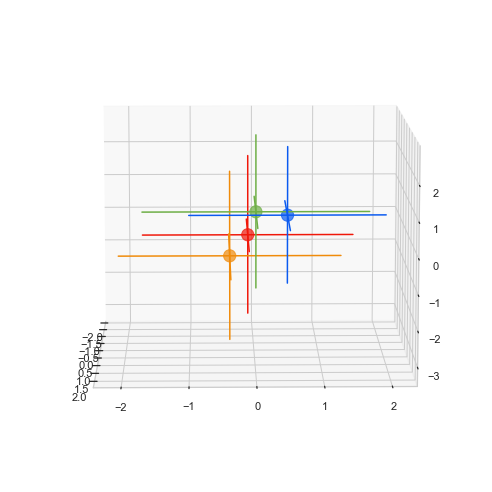

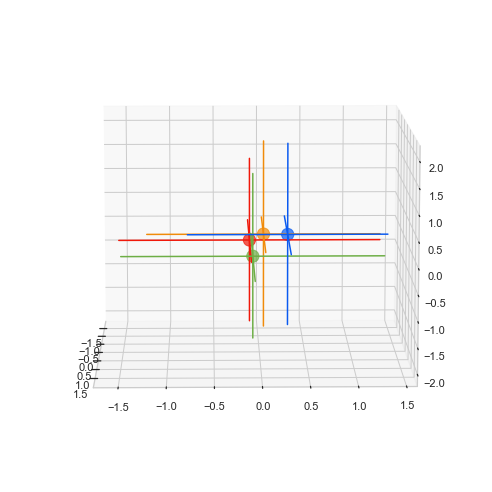

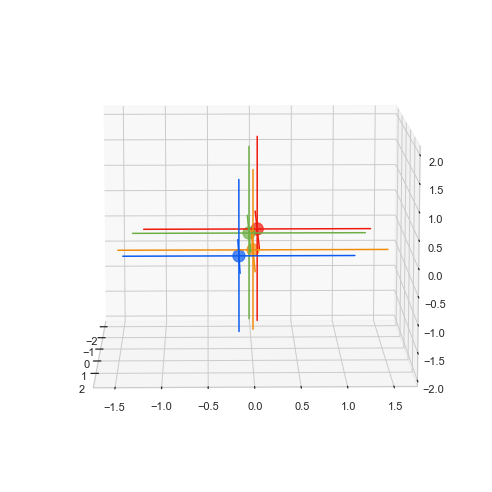

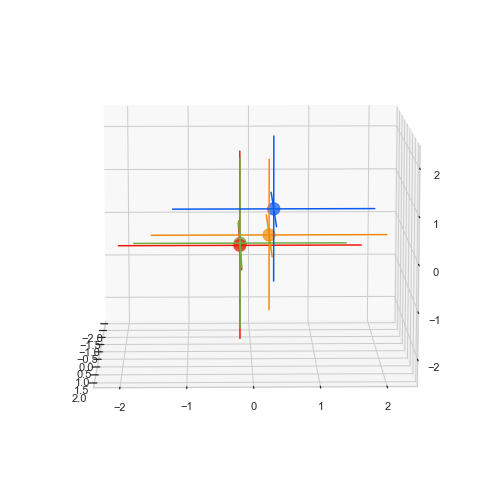

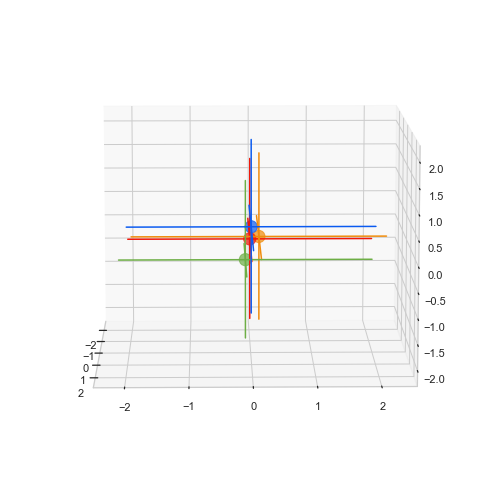

In [429]:
state_mds(state_1_networks, '/Users/jacobderosa/Desktop/GitHub/neurohack_brainstates/figures/mds_plots_of_states/state_1_networks')
state_mds(state_2_networks, '/Users/jacobderosa/Desktop/GitHub/neurohack_brainstates/figures/mds_plots_of_states/state_2_networks')
state_mds(state_3_networks, '/Users/jacobderosa/Desktop/GitHub/neurohack_brainstates/figures/mds_plots_of_states/state_3_networks')
state_mds(state_4_networks, '/Users/jacobderosa/Desktop/GitHub/neurohack_brainstates/figures/mds_plots_of_states/state_4_networks')
state_mds(state_5_networks, '/Users/jacobderosa/Desktop/GitHub/neurohack_brainstates/figures/mds_plots_of_states/state_5_networks')

In [430]:
state_1_long = state_1_networks.iloc[:, 0:18].melt(id_vars='dx')
state_2_long = state_2_networks.iloc[:, 0:18].melt(id_vars='dx')
state_3_long = state_3_networks.iloc[:, 0:18].melt(id_vars='dx')
state_4_long = state_4_networks.iloc[:, 0:18].melt(id_vars='dx')
state_5_long = state_5_networks.iloc[:, 0:18].melt(id_vars='dx')

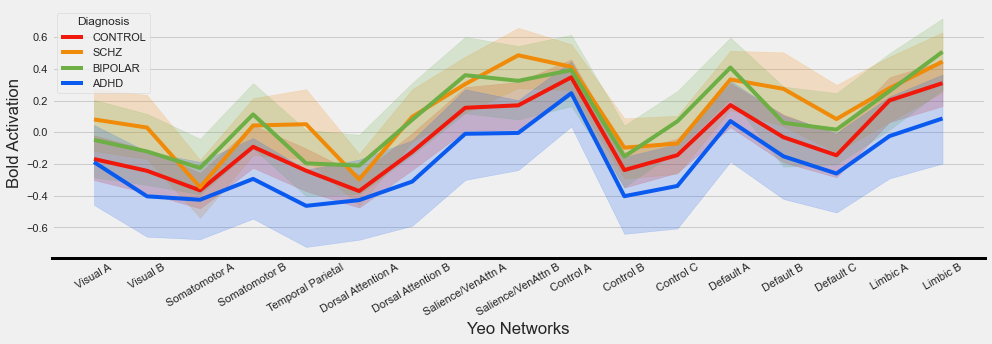

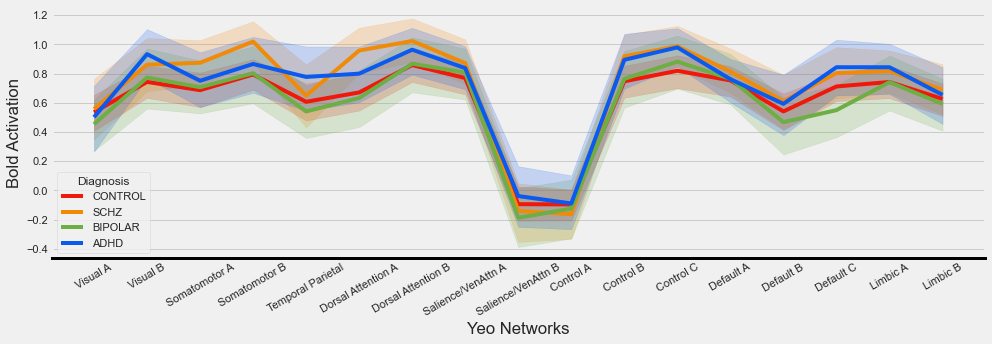

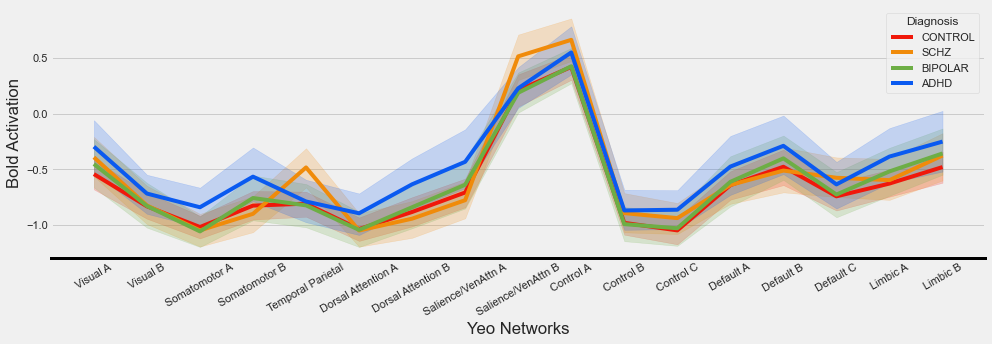

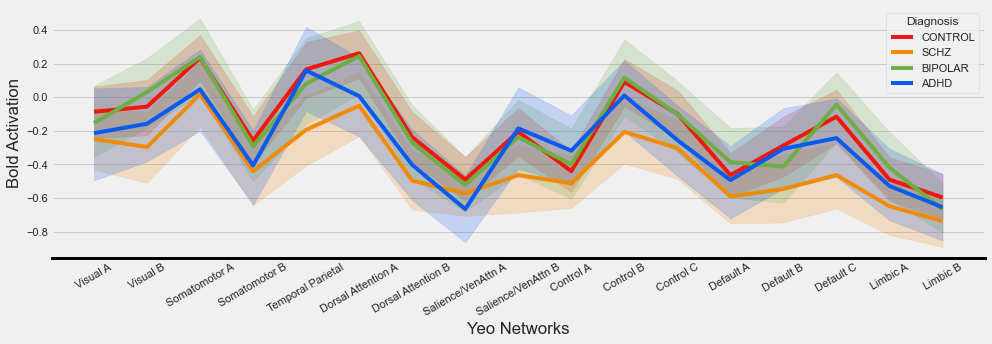

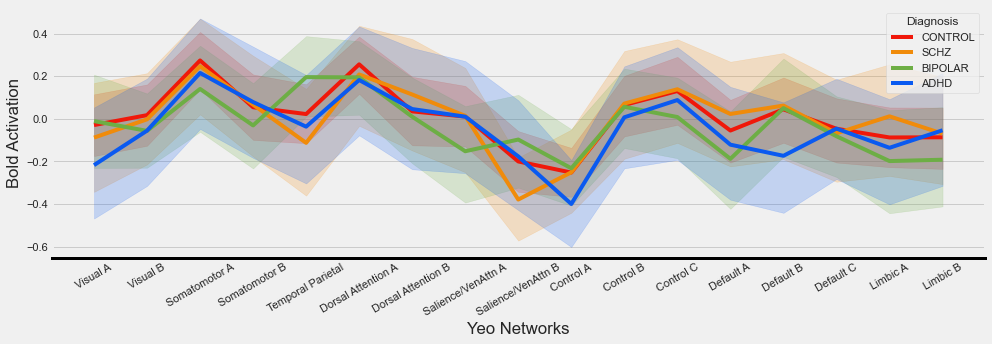

In [431]:
def state_lines(data):
    import seaborn as sns
    plt.style.use('fivethirtyeight')  
    plt.figure(figsize=(14,5))
    
    yeo_labs = ['Visual A', 'Visual B', 'Somatomotor A', 'Somatomotor B', 
                'Temporal Parietal', 'Dorsal Attention A', 'Dorsal Attention B',
                'Salience/VenAttn A',  'Salience/VenAttn B', 'Control A', 'Control B',
                'Control C', 'Default A', 'Default B', 'Default C', 'Limbic A', 'Limbic B']
    
    cmap = ops_cols
    
    data = data.rename({'variable':'Yeo Networks'}, axis=1).rename({'value':'Bold Activation'}, axis=1)
    data['Diagnosis'] = np.where(data['dx'] == 0, 'CONTROL',
                             np.where(data['dx'] == 1, 'ADHD', 
                                      np.where(data['dx'] == 2, 'BIPOLAR',
                                               np.where(data['dx'] == 3, 'SCHZ', False))))
    
    ax = sns.lineplot(data=data, x = 'Yeo Networks', y = 'Bold Activation', palette=cmap, hue="Diagnosis", sort= False)
    
    ax.grid(axis='x')
    plt.xticks(list(range(0,17)), yeo_labs, rotation = 30)
    plt.tight_layout()
    ax.spines['bottom'].set_color('black')
    ax.xaxis.set_ticks_position('bottom') 


state_lines(state_1_long)
state_lines(state_2_long)
state_lines(state_3_long)
state_lines(state_4_long)
state_lines(state_5_long)

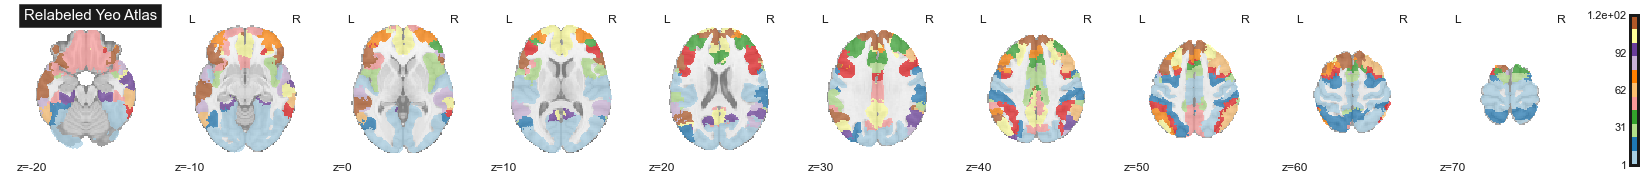

In [432]:
from nilearn import datasets
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011()
atlas_yeo = atlas_yeo_2011.thick_17

from nilearn.regions import connected_label_regions
region_labels = connected_label_regions(atlas_yeo)
nplot.plot_roi(region_labels,
               cut_coords=(-20,-10,0,10,20,30,40,50,60,70),
               display_mode='z',
               colorbar=True,
               cmap='Paired',
               title='Relabeled Yeo Atlas')